In [1]:
import time
import numpy as np
import pandas as pd
import catboost as cb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns", 30)

## Useful Functions

In [2]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "G:\data\geekbrains-competitive-data-analysis"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data


def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
#             eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def catboost_hold_out_validation(params, X, y, split_params = [0.7, 0.2, 0.1], categorical = None):
    """
    Hold-Out валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    split_params: List[float], optional, default = [0.7, 0.2, 0.1]
        Параметры (доли) разбиения выборки.
        Опциональный параметр, по умолчанию, равен [0.7, 0.2, 0.1].
    
    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimator: catboost.core.CatBoostClassifier
        Обученный классификатор catboost.

    test_prediction: np.array, optional
        Вектор прогнозов для тестовой выборки.
        Опциональный объект, возвращается только, если split_params
        содержит 3 значения.

    """
    numeric = list(set(x_train.columns) - set(categorical))
    x_train, x_valid = train_test_split(
        X, train_size=split_params[0], random_state=27
    )
    y_train, y_valid = train_test_split(
        y, train_size=split_params[0], random_state=27
    )

    if len(split_params) == 3:
        test_size = int(split_params[2] * X.shape[0])

        x_valid, x_test = train_test_split(
            x_valid, test_size=test_size, random_state=72
        )
        y_valid, y_test = train_test_split(
            y_valid, test_size=test_size, random_state=72
        )
    
    
    model = cb.CatBoostClassifier(**params, verbose=False)
    model.fit(
        x_train, y_train, categorical,
        eval_set=[(x_train, y_train), (x_valid, y_valid)]
    )

    print("="*80)
    valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
    print(f"Valid Score = {round(valid_score, 4)}")

    if len(split_params) == 3:

        test_prediction = model.predict_proba(x_test)[:, 1]
        test_score = roc_auc_score(y_test, test_prediction)
        print(f"Test Score = {round(test_score, 4)}")

        return estimator, test_prediction

    else:
        return estimator

In [3]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)
    
    X["external_scoring_men_sqer1"] = (X["external_scoring_rating_1"]-X["external_scoring_rating_1"].mean())**2/X["external_scoring_rating_1"].mean()
    X["external_scoring_men_sqer2"] = (X["external_scoring_rating_2"]-X["external_scoring_rating_2"].mean())**2/X["external_scoring_rating_2"].mean()
    X["external_scoring_men_sqer3"] = (X["external_scoring_rating_3"]-X["external_scoring_rating_3"].mean())**2/X["external_scoring_rating_3"].mean()
    
    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]
    
    
    
    X["log_total_salary"] = np.log(X["total_salary"])
    X["log_amount_credit"] = np.log(X["amount_credit"])
    X["log_amount_credity"] = np.log(X["amount_annuity"])

    return X

In [4]:
def bki_process (df, list_values, index, columns, list_cat):
    
    df_1 = pd.DataFrame()
    
    for value in list_values:
        data = df.pivot_table(values=value, index=index, columns=columns, aggfunc=np.mean, fill_value=0)
        data.columns = ["_".join([data.columns.name,value, col]) for col in data.columns.values]
        data = data.reset_index()
        if df_1.shape[0] == 0:
            df_1  = data
        else:
            df_1 = df_1.merge(data, on=list_index, how='left')
            
    for cat in list_cat:
        data = df.pivot_table(index=index, columns=columns, \
                values=cat,  aggfunc=lambda x: x.value_counts().index.tolist()[0] , fill_value=0)
        data.columns = ["_".join([data.columns.name, cat, col]) for col in data.columns.values]
        data = data.reset_index()
        if df_1.shape[0] == 0:
            df_1  = data
        else:
            df_1 = df_1.merge(data, on=list_index, how='left')
    
    return df_1

## Base Tables

In [5]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


## client_profile

In [6]:
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

client_profile.csv: shape = 250000 rows, 24 cols


D:\anaconda3\envs\CNN\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,...,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,log_total_salary,log_amount_credit,log_amount_credity
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,...,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,11.967181,12.506177,9.510445
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,...,NaN,NaN,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462,12.506177,13.193600,10.256501


In [7]:
payments = get_input("payments.csv")
payments['installment_payment_ratio'] = payments["amt_instalment"]/payments['amt_payment']
payments['day_instalment_payment_ratio'] = payments["days_instalment"]/payments['days_entry_payment']

bki = get_input("bki.csv")
bki['day_fact_enddate'] = bki['days_enddate_fact'] / bki['days_credit_enddate']
bki['dlr'] = (bki['amt_credit_sum_debt']+0)/(bki['amt_credit_sum']+1) 
bki['ratio_overdue'] = (bki['amt_credit_max_overdue']+0)/(bki['amt_credit_sum']+1)

appl_history = get_input("applications_history.csv")
appl_history['count_history'] = appl_history.groupby(['application_number'])['prev_application_number'].count()

payments.csv: shape = 1023932 rows, 8 cols
bki.csv: shape = 945234 rows, 17 cols
applications_history.csv: shape = 1670214 rows, 26 cols


In [8]:
list_index = 'application_number'

list_values = ['days_credit', 
               'credit_day_overdue',
               'days_credit_enddate',
               'days_enddate_fact',
               'amt_credit_max_overdue', 
               'cnt_credit_prolong',
               'amt_credit_sum',
               'amt_credit_sum_debt',
               'amt_credit_sum_limit',
               'amt_credit_sum_overdue',
               'days_credit_update',
               'amt_annuity',
               'day_fact_enddate', 
               'dlr', 
               'ratio_overdue']

list_columns = 'credit_active'

list_cat = ['credit_type', 'credit_currency']

bki = bki_process (bki, list_values, list_index, list_columns, list_cat)

In [9]:
payments = payments.groupby('application_number').mean()
data = data.merge(
    payments, how="left", on="application_number"
)
bki = bki.groupby('application_number').mean()
data = data.merge(
    bki, how="left", on="application_number"
)

appl_history = appl_history.groupby('application_number').mean()
data = data.merge(
    appl_history, how="left", on="application_number"
)

In [10]:
data = data.merge(
    client_profile, how="left", on="application_number"
)

In [11]:
for categorical in data.select_dtypes(include=["object"]).columns.tolist():
        data[categorical]=data[categorical].astype('category').cat.codes

## baseline

In [12]:
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]


train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

In [13]:
x_train, x_test = train_test_split(train, train_size=0.6, random_state=13)
y_train, y_test = train_test_split(target, train_size=0.6, random_state=13)
x_valid, x_test = train_test_split(x_test, train_size=0.5, random_state=13)
y_valid, y_test = train_test_split(y_test, train_size=0.5, random_state=13)

In [22]:
xgb_params = {
    "learning_rate": 0.15,
    "n_estimators": 5000,
    "max_depth": 5,
    "min_child_weight":1,
    "gamma":0,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "objective":'binary:logistic',
    "nthread":6,
    "scale_pos_weight":1,
    "seed":13
}

In [23]:
dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=100, 
)
col = x_train.columns
pred = model.predict(xgb.DMatrix(x_test))
test_score = roc_auc_score(y_test, pred)
print(f"Test Score = {round(test_score, 4)}")
train['xgb'] = model.predict(xgb.DMatrix(train[col]))
test['xgb'] = model.predict(xgb.DMatrix(test[col]))

[13:31:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.08081	valid-error:0.08206
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 20 rounds.
Stopping. Best iteration:
[15]	train-error:0.07998	valid-error:0.08029

Test Score = 0.7172


In [30]:
lgbm_params = {
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance':True,
        'boosting':'gbdt',        
        "n_estimators": 1000,
        'num_boost_round':300,
        'early_stopping_rounds':30,
        'learning_rate': 0.05,
        'max_depth': 20,
        'num_leaves': 12,
        'feature_fraction': 0.8,
        'subsample': 0.2}


In [31]:
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_valid, label=y_valid)

model = lgb.train(
    params = lgbm_params,
    train_set = train_data,
    valid_sets = test_data,
    verbose_eval=10,
)

pred = model.predict(x_test)
test_score = roc_auc_score(y_test, pred)
print(f"Test Score = {round(test_score, 4)}")
train['lgb'] = model.predict(train[col])
test['lgb'] = model.predict(test[col])

D:\anaconda3\envs\CNN\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda3\envs\CNN\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda3\envs\CNN\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5365, number of negative: 60690
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23298
[LightGBM] [Info] Number of data points in the train set: 66055, number of used features: 141
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081220 -> initscore=-2.425883
[LightGBM] [Info] Start training from score -2.425883
Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.712511
[20]	valid_0's auc: 0.715412
[30]	valid_0's auc: 0.719732
[40]	valid_0's auc: 0.723395
[50]	valid_0's auc: 0.72539
[60]	valid_0's auc: 0.726485
[70]	valid_0's auc: 0.726717
[80]	valid_0's auc: 0.728265
[90]	valid_0's auc: 0.729266
[100]	valid_0's auc: 

In [33]:
col = ['external_scoring_rating_mean',
       'ratio_credit_to_annuity',
       'external_scoring_rating_max',
       'external_scoring_rating_nanmedian',
       'external_scoring_rating_min',
       'education_level',
       'external_scoring_rating_3',
       'name_contract_type',
       'gender',
       'ratio_age_to_experience',
       'ratio_credit_to_experience',
       'external_scoring_prod',
       'ratio_annuity_to_age',
       'external_scoring_rating_2',
       'ratio_credit_to_salary',
       'external_scoring_rating_1',
       'ratio_car_to_age',
       'lgb',
       'xgb',    
    ]

## KFold

In [42]:
cb_params = {
    "n_estimators": 3000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 50,
    "silent": True,
    "max_depth": 6,
    "l2_leaf_reg": 20,
    "early_stopping_rounds": 50,
    "thread_count": 7,
    "random_seed": 13,
}

cv = KFold(n_splits=5, random_state=13, shuffle=True)

estimators, oof_preds = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cv, categorical=categorial
)

Tue Oct  6 13:43:39 2020, Cross-Validation, 110093 rows, 144 cols
Fold 1, Valid score = 0.71275
Fold 2, Valid score = 0.72183
Fold 3, Valid score = 0.79759
Fold 4, Valid score = 0.79346
Fold 5, Valid score = 0.79356
Score by each fold: [0.71275, 0.72183, 0.79759, 0.79346, 0.79356]


In [43]:
oof_score = roc_auc_score(
    target, oof_preds
)
print(f"OOF-score = {round(oof_score, 5)}")
# [0.72194, 0.72659, 0.73283, 0.72053, 0.72657]
# OOF-score = 0.72481
# 0.72574

OOF-score = 0.76274


In [44]:
import matplotlib.pyplot as plt
import shap

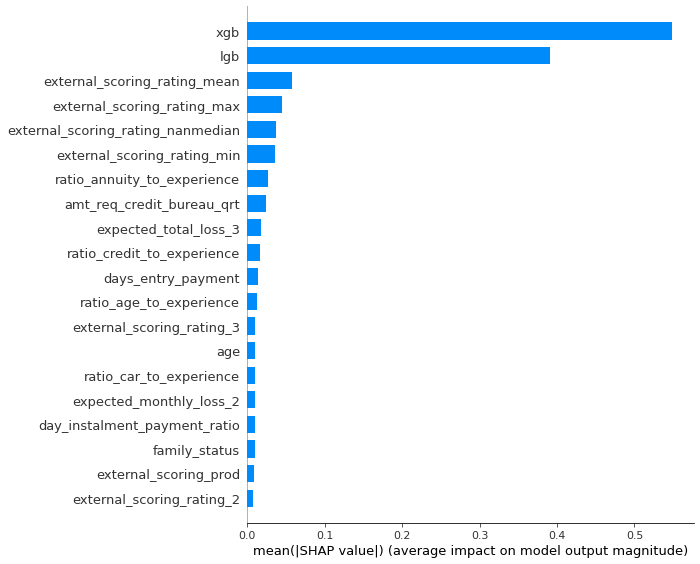

In [45]:
shap_values = shap.TreeExplainer(estimators[2]).shap_values(train)
shap.summary_plot(shap_values, train, plot_type="bar")

## Подготовка прогноза

In [48]:
train.head(3)

,name_contract_type,prev_application_number_x,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment,installment_payment_ratio,day_instalment_payment_ratio,credit_active_days_credit_Active,credit_active_days_credit_Bad debt,credit_active_days_credit_Closed,credit_active_days_credit_Sold,credit_active_credit_day_overdue_Active,...,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,log_total_salary,log_amount_credit,log_amount_credity,xgb,lgb
0,0,49754880.5,1.0,5.75,2653.00,2659.0,6275.9250,3960.37125,224.47528,0.997614,0.0,0.0,2562.000000,0.0,0.0,...,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,11.967181,13.658857,10.131738,0.020728,0.164675
1,0,49672074.0,1.0,9.00,450.00,457.0,11349.9000,11349.90000,1.00000,0.984683,494.5,0.0,1169.600000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091476,0.536274
2,0,49376832.5,0.5,10.00,1917.25,1917.5,20169.4725,20169.47250,1.00000,0.994662,1464.0,0.0,1700.857143,0.0,0.0,...,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803,11.813030,13.822407,10.661017,0.069128,0.468175


In [46]:
y_pred = np.zeros(test[col].shape[0])
test[numerical] = test[numerical].astype(float)
test[categorial] = test[categorial].astype(str)

for estimator in estimators:
    y_pred += estimator.predict_proba(test)[:, 1]

In [47]:
y_pred = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred / cv.n_splits
})
y_pred.to_csv("baseline_submit.csv", index=False)